# Cell 1: Imports

In [25]:
import math
import csv
from dataclasses import dataclass
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Cell 2: Models

In [26]:
@dataclass
class Task:
    name: str
    period_ms: float
    exec_ms: float
    deadline_ms: float = None  # if None, we'll use period_ms

    def __post_init__(self):
        if self.deadline_ms is None:
            self.deadline_ms = self.period_ms


@dataclass
class JobRecord:
    task: str
    alpha: float
    release: float
    start: float
    finish: float
    deadline: float
    response: float
    waiting: float
    tardiness: float
    miss: int
    utility: float

# Cell 3: Simulation

In [27]:
def simulate_edf(tasks, sim_time_ms=60_000, alpha_load=1.0,
                 dt_ms=1.0, util_scale_ms=50.0):
    """
    Run a uniprocessor EDF simulation.

    tasks        : list[Task]
    sim_time_ms  : total simulation time in ms
    alpha_load   : multiply each task.exec_ms by this factor (system load)
    dt_ms        : time resolution (smaller = more accurate, slower)
    util_scale_ms: utility fall-off scale for tardiness

    Returns: list[JobRecord]
    """
    # When each task will release its next job
    next_release = {t.name: 0.0 for t in tasks}

    # All active jobs (not finished yet)
    active_jobs = []

    results = []

    t = 0.0
    while t < sim_time_ms:
        # 1) Release new jobs
        for task in tasks:
            # If time has crossed the next release, emit jobs until we catch up
            while t >= next_release[task.name]:
                rel = next_release[task.name]
                dl = rel + task.deadline_ms
                active_jobs.append({
                    "task": task,
                    "release": rel,
                    "deadline": dl,
                    "remaining": task.exec_ms * alpha_load,
                    "first_start": None
                })
                next_release[task.name] += task.period_ms

        # 2) Select job with earliest deadline among active ready jobs
        current = None
        earliest_dl = math.inf

        for job in active_jobs:
            if job["release"] <= t and job["remaining"] > 0:
                if job["deadline"] < earliest_dl:
                    earliest_dl = job["deadline"]
                    current = job

        # 3) Execute for dt_ms (or idle)
        if current is not None:
            if current["first_start"] is None:
                current["first_start"] = t

            current["remaining"] -= dt_ms
            finished = current["remaining"] <= 0

            if finished:
                finish_time = t + dt_ms

                response = finish_time - current["release"]
                waiting = current["first_start"] - current["release"]
                tardiness = max(0.0, finish_time - current["deadline"])
                miss = 1 if finish_time > current["deadline"] else 0
                utility = max(0.0, 1.0 - tardiness / util_scale_ms)

                results.append(
                    JobRecord(
                        task=current["task"].name,
                        alpha=alpha_load,
                        release=current["release"],
                        start=current["first_start"],
                        finish=finish_time,
                        deadline=current["deadline"],
                        response=response,
                        waiting=waiting,
                        tardiness=tardiness,
                        miss=miss,
                        utility=utility,
                    )
                )

                active_jobs.remove(current)

        # 4) Advance time
        t += dt_ms

    return results

# Cell 4

In [28]:
def summarize_jobs_with_metrics(jobs):
    if not jobs:
        cols = ["scheduler", "task", "alpha",
                "avg_latency_ms", "jitter_ms",
                "avg_tardiness_ms", "miss_ratio",
                "avg_utility"]
        return (pd.DataFrame(columns=[
                    "scheduler","task","alpha",
                    "release","deadline","start","finish",
                    "response","tardiness","miss","utility"
                ]),
                pd.DataFrame(columns=cols))

    df = pd.DataFrame(jobs)

    # per-task, per-scheduler, per-alpha metrics
    group_cols = ["scheduler", "task", "alpha"]
    grouped = df.groupby(group_cols)

    summary = grouped.agg(
        avg_latency_ms=("response", "mean"),
        jitter_ms=("response", "std"),
        avg_tardiness_ms=("tardiness", "mean"),
        miss_ratio=("miss", "mean"),          # fraction of jobs that missed
        avg_utility=("utility", "mean")
    ).reset_index()

    # Fill NaN jitter (only 1 job) with 0
    summary["jitter_ms"] = summary["jitter_ms"].fillna(0.0)

    return df, summary


def save_csv(df_jobs, df_summary,
             jobs_path="edf_jobs.csv",
             summary_path="edf_summary.csv"):
    df_jobs.to_csv(jobs_path, index=False)
    df_summary.to_csv(summary_path, index=False)
    print(f"Wrote {jobs_path} and {summary_path}")

# Cell 5: Plots


In [29]:
# ============================================================
#  PROFESSIONAL EDF PLOTS — FUNCTIONS ONLY
# ============================================================

import matplotlib.pyplot as plt

# --- GLOBAL STYLING ---
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "axes.facecolor": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "axes.grid": True,
    "font.size": 12,
    "font.family": "serif",
    "lines.linewidth": 2.2,
    "lines.markersize": 7,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.edgecolor": "black",
})

def plot_all_edf(df_summary, df_jobs, example_task, title_prefix="EDF Scheduling Performance Summary"):
    """
    Create a 2×2 dashboard:
      (1) Latency vs α
      (2) Utility vs α
      (3) Frame delay histogram (example_task)
      (4) Tardiness vs time (example_task)
    """
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    ax1, ax2, ax3, ax4 = axs.ravel()

    # -----------------------------
    # 1) LATENCY vs α
    # -----------------------------
    for task in sorted(df_summary["task"].unique()):
        sub = df_summary[df_summary["task"] == task].sort_values("alpha")
        ax1.plot(sub["alpha"], sub["avg_latency_ms"], marker="o", label=task)

    ax1.set_title("Average Latency vs Load Factor α", fontsize=14, weight="bold")
    ax1.set_xlabel("Load factor α")
    ax1.set_ylabel("Average response time [ms]")
    ax1.legend(title="Task")

    # -----------------------------
    # 2) UTILITY vs α
    # -----------------------------
    for task in sorted(df_summary["task"].unique()):
        sub = df_summary[df_summary["task"] == task].sort_values("alpha")
        ax2.plot(sub["alpha"], sub["avg_utility"], marker="s", label=task)

    ax2.set_title("Average Utility vs Load Factor α", fontsize=14, weight="bold")
    ax2.set_xlabel("Load factor α")
    ax2.set_ylabel("Utility (0–1)")
    ax2.set_ylim(0, 1.05)
    ax2.legend(title="Task")

    # -----------------------------
    # 3) FRAME DELAY HISTOGRAM
    # -----------------------------
    sub = df_jobs[df_jobs["task"] == example_task]

    ax3.hist(sub["response"], bins=25, edgecolor="black", alpha=0.85)
    ax3.set_title(f"Frame Delay Distribution — {example_task}", fontsize=14, weight="bold")
    ax3.set_xlabel("Response time [ms]")
    ax3.set_ylabel("Frequency")

    # -----------------------------
    # 4) TARDINESS vs TIME
    # -----------------------------
    sub = df_jobs[df_jobs["task"] == example_task].sort_values("release")

    ax4.plot(sub["release"], sub["tardiness"], marker=".", linestyle="-")
    ax4.set_title(f"Tardiness Over Time — {example_task}", fontsize=14, weight="bold")
    ax4.set_xlabel("Release time [ms]")
    ax4.set_ylabel("Tardiness [ms]")

    fig.suptitle(title_prefix, fontsize=18, weight="bold")
    fig.tight_layout()
    return fig

# Cell 6: General EDF

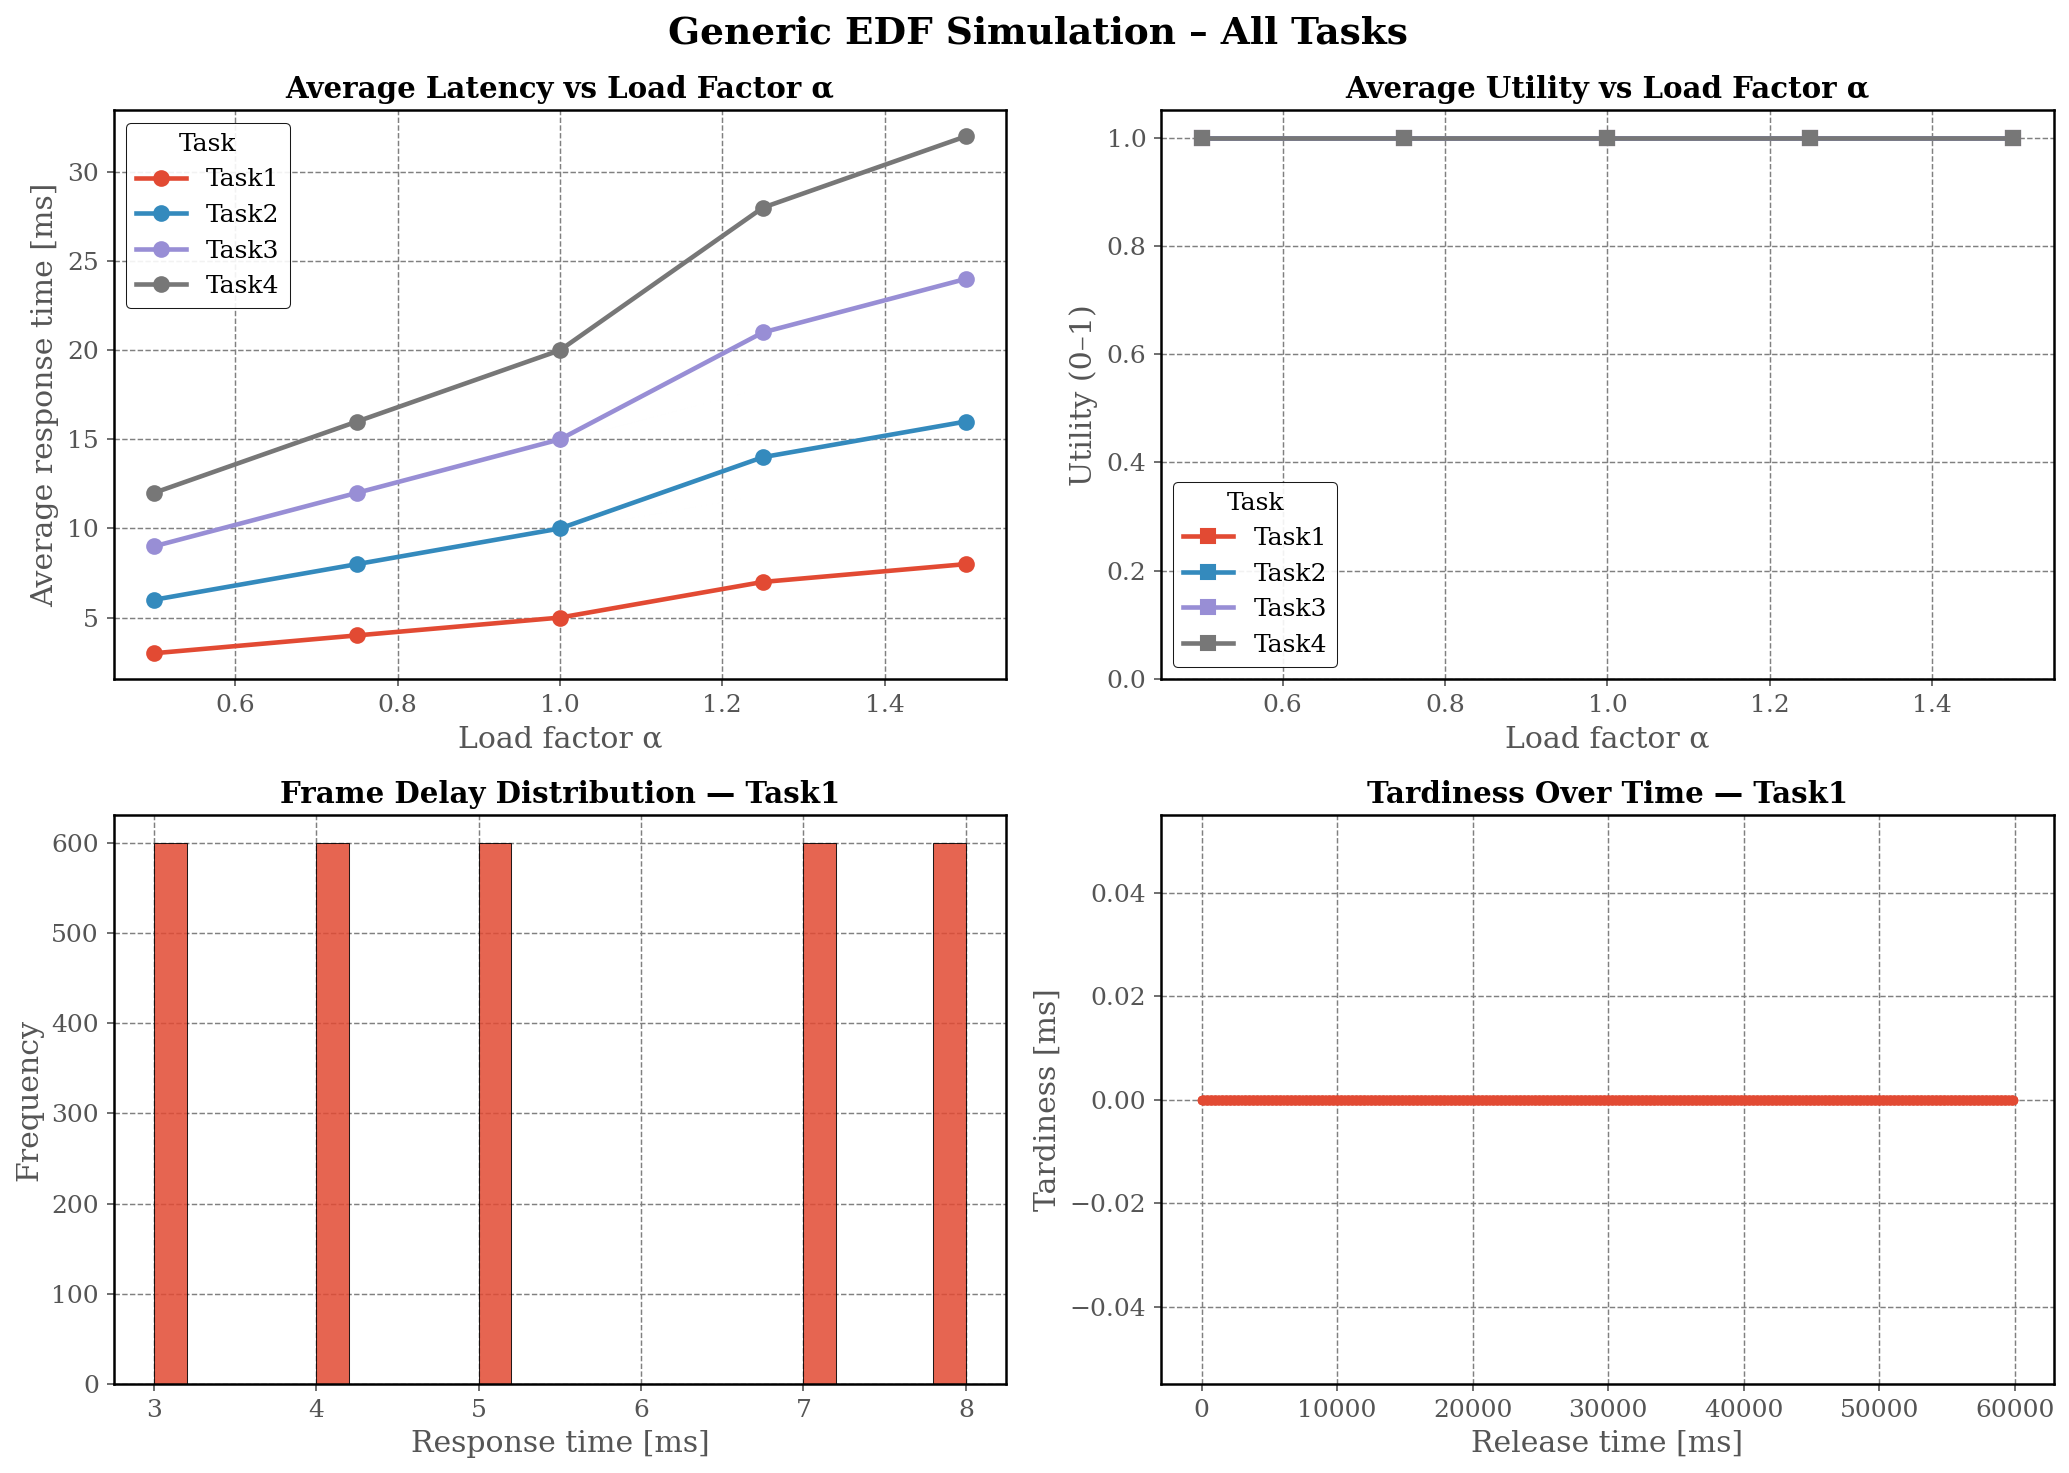

In [30]:
# Cell 6: Interactive generic EDF configuration with sliders

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display, clear_output

def parse_alpha_list_str(s, default="0.5,0.75,1.0,1.25,1.5"):
    """
    Parse a comma-separated string of alpha values into a list of floats.
    If empty, uses default.
    """
    s = s.strip()
    if not s:
        s = default
    parts = [p.strip() for p in s.split(",") if p.strip()]
    alphas = []
    for p in parts:
        try:
            alphas.append(float(p))
        except ValueError:
            print(f"Ignoring invalid alpha value: {p}")
    return alphas


# --- Widgets ---------------------------------------------------------

n_tasks_slider = widgets.IntSlider(
    value=4,
    min=1,
    max=50,
    step=1,
    description="Sensors:",
    continuous_update=False
)

period_slider = widgets.FloatSlider(
    value=100.0,
    min=10.0,
    max=1000.0,
    step=10.0,
    description="Period T [ms]:",
    continuous_update=False
)

exec_slider = widgets.FloatSlider(
    value=5.0,
    min=1.0,
    max=period_slider.value,
    step=1.0,
    description="Exec C [ms]:",
    continuous_update=False
)

# make C slider always <= T
def _sync_exec_range(change):
    exec_slider.max = change["new"]
period_slider.observe(_sync_exec_range, names="value")

sim_time_text = widgets.FloatText(
    value=60_000.0,
    description="Sim time [ms]:"
)

alpha_text = widgets.Text(
    value="0.5,0.75,1.0,1.25,1.5",
    description="α list:",
    layout=widgets.Layout(width="60%")
)

run_button = widgets.Button(
    description="Run EDF Simulation",
    button_style="success",
    tooltip="Run EDF with current parameters",
    icon="play"
)

output = widgets.Output()


# --- EDF runner ---------------------------------------------------------

def run_edf_simulation(_):
    with output:
        clear_output()
        print("=== Running EDF generic simulation ===")

        n_tasks    = int(n_tasks_slider.value)
        base_T     = float(period_slider.value)
        base_C     = float(exec_slider.value)
        sim_time   = float(sim_time_text.value)
        alpha_list = parse_alpha_list_str(alpha_text.value)

        # Quick sanity: C <= T
        if base_C > base_T:
            print("ERROR: Execution time C must be ≤ period T.")
            return

        # Build tasks: same T, C, D for all
        tasks_generic = []
        for i in range(n_tasks):
            tasks_generic.append(Task(
                name=f"Task{i+1}",
                period_ms=base_T,
                exec_ms=base_C,
                deadline_ms=base_T  # deadline = period
            ))

        print(f"Number of tasks: {n_tasks}")
        print(f"Task model: T={base_T} ms, C={base_C} ms, D={base_T} ms")
        print("α values:", alpha_list)
        print(f"Simulation time: {sim_time} ms")

        # Run simulations for all alphas
        all_jobs_generic = []
        for alpha in alpha_list:
            jobs = simulate_edf(tasks_generic,
                                sim_time_ms=sim_time,
                                alpha_load=alpha,
                                dt_ms=1.0,
                                util_scale_ms=base_T)  # utility scale ~ period
            print(f"[GENERIC] α={alpha}: {len(jobs)} jobs")
            all_jobs_generic.extend(jobs)

        # Summaries + CSV
        df_jobs_generic, df_summary_generic = summarize_jobs(all_jobs_generic)

        save_csv(
            df_jobs_generic,
            df_summary_generic,
            "edf_jobs_generic.csv",
            "edf_summary_generic.csv"
        )
        print("Saved CSV: edf_jobs_generic.csv, edf_summary_generic.csv")

        # === Combined 2×2 dashboard for the GENERIC model ===
        if len(df_jobs_generic) > 0:
            example_task = df_summary_generic["task"].unique()[0]
            print(f"\n[GENERIC] Plotting EDF dashboard for: {example_task}")
            plot_all_edf(
                df_summary_generic,
                df_jobs_generic,
                example_task,
                title_prefix="Generic EDF Simulation – All Tasks"
            )
        else:
            print("\nNo jobs generated → skipping plots.")


run_button.on_click(run_edf_simulation)

# Layout
controls_row1 = HBox([n_tasks_slider, period_slider, exec_slider])
controls_row2 = HBox([sim_time_text, alpha_text])

display(
    VBox([
        controls_row1,
        controls_row2,
        run_button,
        output
    ])
)

# Cell 7: Project Specific

=== Project EDF Simulation (STM32/ESP32 task set) ===
Tasks: ['Ultra', 'Sound', 'PIR', 'Button']
α values: [0.5, 0.75, 1.0, 1.25, 1.5]
Simulation time: 60000 ms
[PROJECT] alpha=0.5: 570 jobs
[PROJECT] alpha=0.75: 570 jobs
[PROJECT] alpha=1.0: 570 jobs
[PROJECT] alpha=1.25: 570 jobs
[PROJECT] alpha=1.5: 570 jobs
Wrote edf_jobs_project.csv and edf_summary_project.csv
Wrote edf_jobs_project.csv and edf_summary_project.csv

[PROJECT] Plotting EDF dashboard for: Button


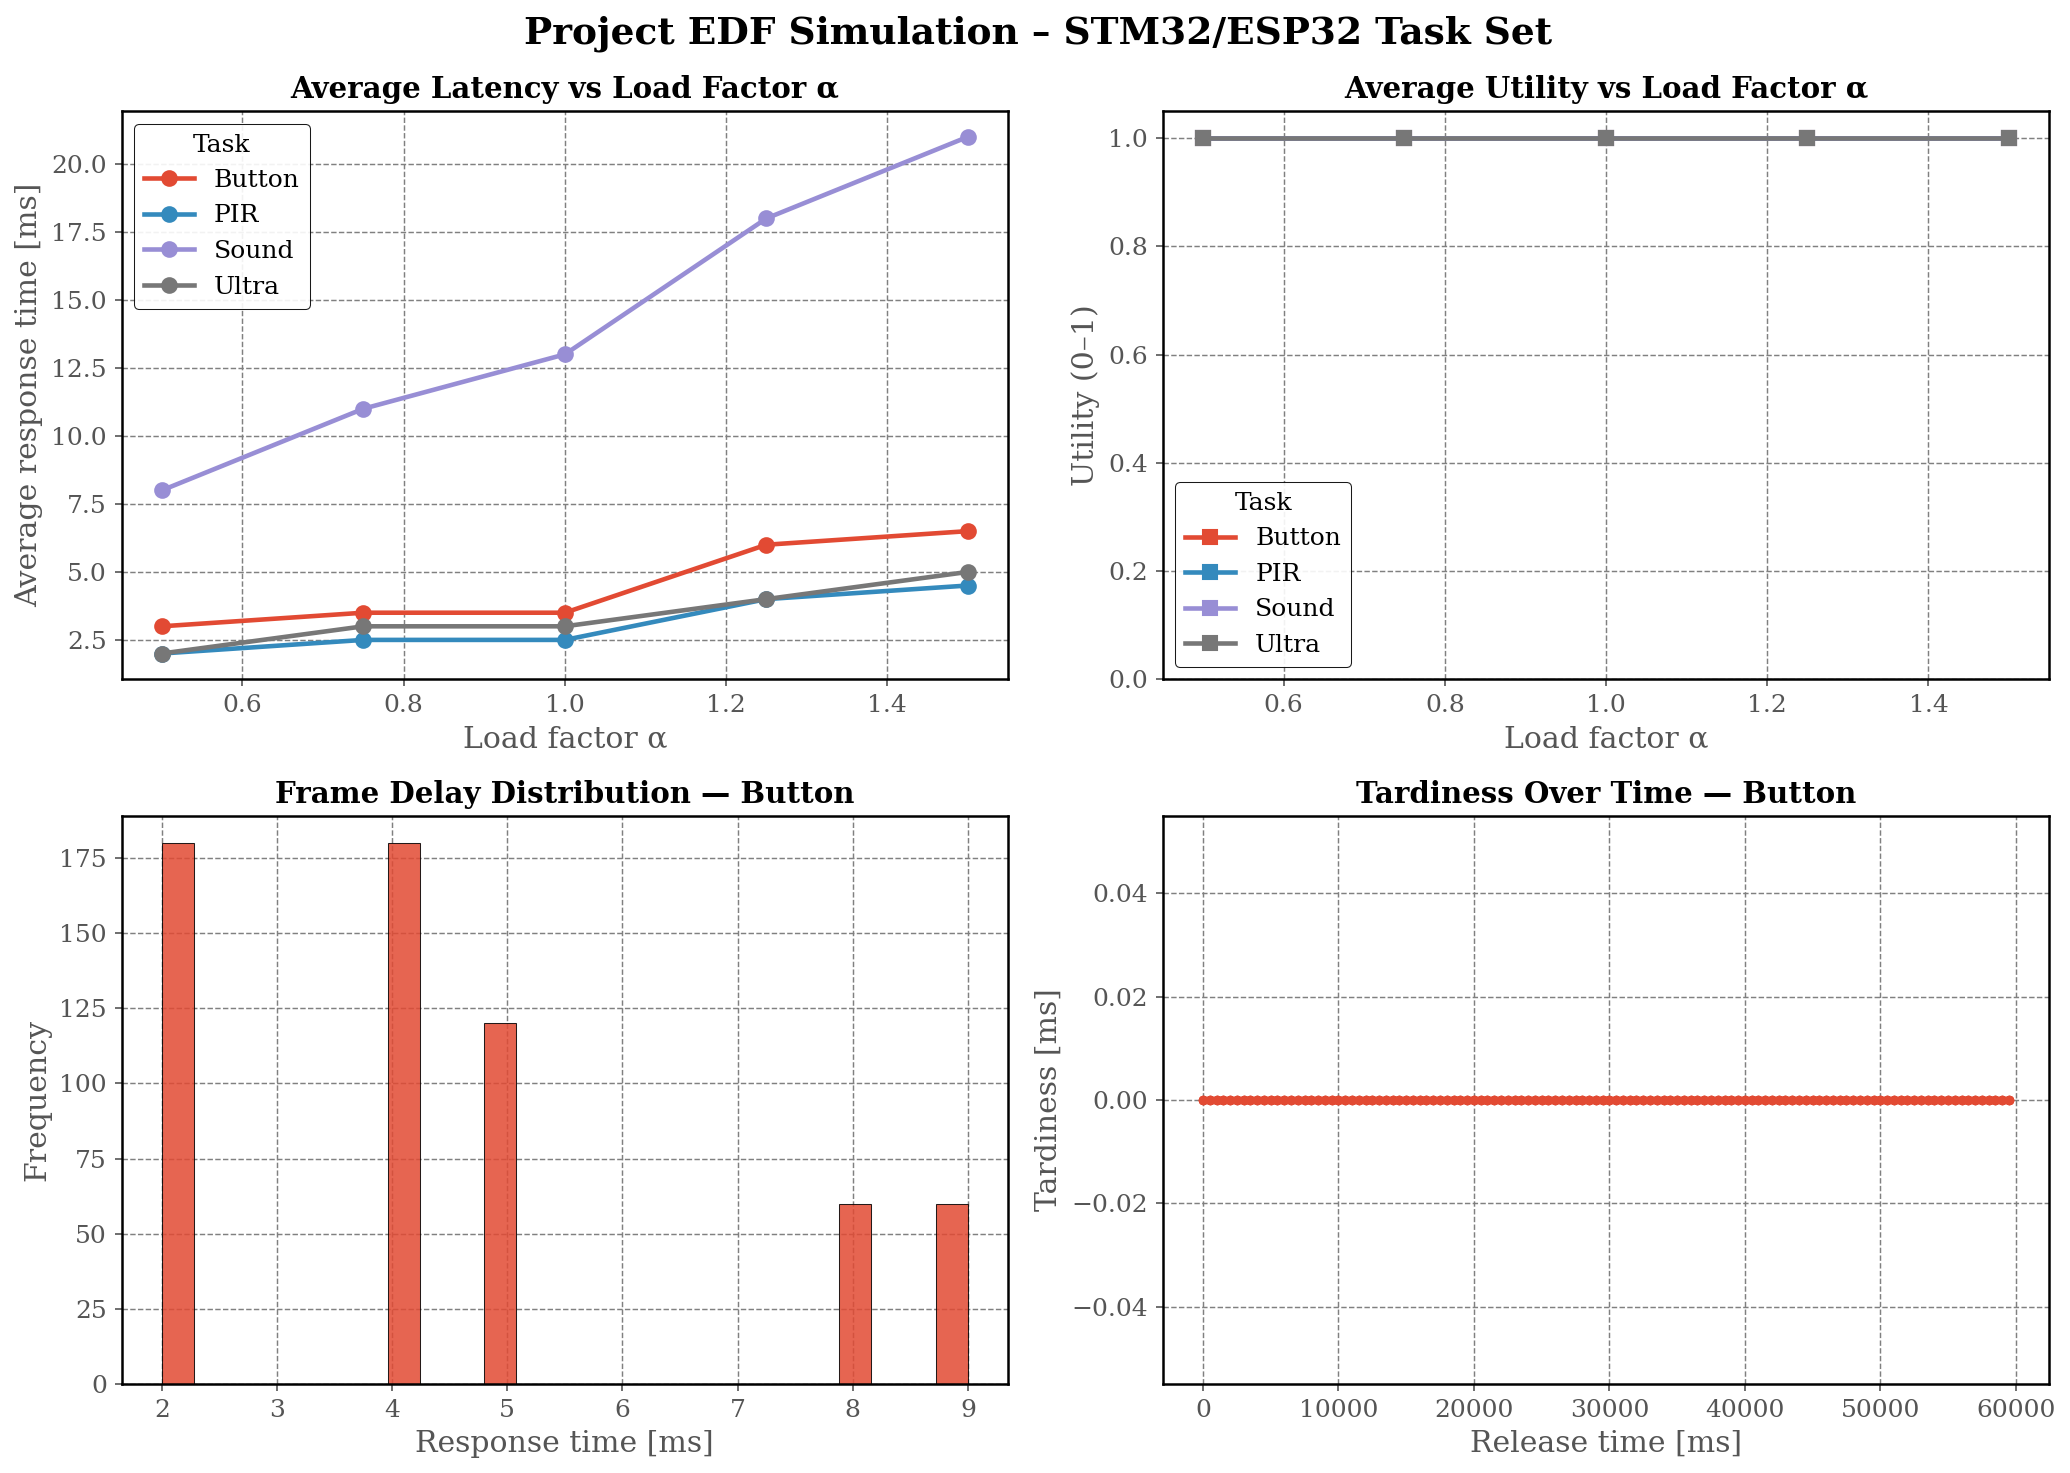

In [31]:
# ============================================================
#  PROJECT-SPECIFIC EDF SIMULATION (STM32/ESP32 TASK SET)
# ============================================================

# Task set matching your real project
tasks_project = [
    Task("Ultra",  period_ms=200,  exec_ms=3,  deadline_ms=200),   # control loop
    Task("Sound",  period_ms=2000, exec_ms=8,  deadline_ms=2000),  # monitoring
    Task("PIR",    period_ms=500,  exec_ms=1,  deadline_ms=200),   # critical-ish
    Task("Button", period_ms=500,  exec_ms=1,  deadline_ms=200),   # control input
]

sim_time_ms = 60_000
alpha_list  = [0.5, 0.75, 1.0, 1.25, 1.5]

print("=== Project EDF Simulation (STM32/ESP32 task set) ===")
print(f"Tasks: {[t.name for t in tasks_project]}")
print(f"α values: {alpha_list}")
print(f"Simulation time: {sim_time_ms} ms")

all_jobs_proj = []
for alpha in alpha_list:
    jobs = simulate_edf(
        tasks_project,
        sim_time_ms=sim_time_ms,
        alpha_load=alpha,
        dt_ms=1.0,
        util_scale_ms=50.0
    )
    print(f"[PROJECT] alpha={alpha}: {len(jobs)} jobs")
    all_jobs_proj.extend(jobs)

# Summaries + CSV
df_jobs_proj, df_summary_proj = summarize_jobs(all_jobs_proj)
save_csv(
    df_jobs_proj,
    df_summary_proj,
    "edf_jobs_project.csv",
    "edf_summary_project.csv"
)
print("Wrote edf_jobs_project.csv and edf_summary_project.csv")

# 2×2 professional dashboard for the PROJECT model
if len(df_jobs_proj) > 0:
    example_task_proj = df_summary_proj["task"].unique()[0]
    print(f"\n[PROJECT] Plotting EDF dashboard for: {example_task_proj}")
    plot_all_edf(
        df_summary_proj,
        df_jobs_proj,
        example_task_proj,
        title_prefix="Project EDF Simulation – STM32/ESP32 Task Set"
    )
else:
    print("\nNo project jobs generated → skipping plots.")